# Building Type Data
- What does intensity look like for each building type? 
    - Hospitals the worst- most in district 3
    - College/university also bad and they ALSO have labs, data centers
- Sum total emissions, square footage by each building type
- Currently in mayor's proposal vs. what we want
- Stretch goal: cute visualization for people in legislation
- total ghg per building type and also as a fraction of city-wide emissions

In [3]:
import numpy as np
import pandas as pd
import geopandas as gp
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt
import util
from scipy import stats
import seaborn as sns

# 1.0 Preprocessing

In [33]:
df_cats = pd.read_csv('../data/CategoryMapping.csv')
df_cats = df_cats[['EPA Building types.1', 'Mapping to legislation building types']]
df_cats.columns = ["EPAPropertyType", "LegislationBuildingType"]
dict_cats = dict(zip(df_cats.EPAPropertyType, df_cats.LegislationBuildingType))


In [15]:
df_districts = gp.read_file("../data/Council_Districts.geojson")
df = pd.read_csv('../data/2020_Building_Energy_Benchmarking.csv')
df = gp.GeoDataFrame(df, geometry=gp.points_from_xy(df.Longitude, df.Latitude))
util.clean_districts(df, df_districts)

Building WATERWORKS OFFICE & MARINA 2353/ 4088803975 doesn't have a district POINT (-122.33895 47.63575) 
	 Found district 7 for WATERWORKS OFFICE & MARINA
Building NAUTICAL LANDING 2381/ 4088804350 doesn't have a district POINT (-122.34219 47.64306) 
	 Found district 7 for NAUTICAL LANDING
Building UNION HARBOR CONDOMINIUM 2540/ 8807200000 doesn't have a district POINT (-122.33003 47.6401) 
	 Found district 4 for UNION HARBOR CONDOMINIUM
Building THE PIER AT LESCHI 2997/ 6780900000 doesn't have a district POINT (-122.28563 47.59926) 
	 Found district 3 for THE PIER AT LESCHI
Building THE LAKESHORE 3046/ 1180001715 doesn't have a district POINT EMPTY 


c:\Users\linne\miniconda3\envs\bps\lib\site-packages\shapely\predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


Building EDUCARE 3218/ 2895800030 doesn't have a district POINT EMPTY 


In [35]:
df = df[['OSEBuildingID', 
        'BuildingName', 
        'CouncilDistrictCode', 
        'YearBuilt', 
        'TotalGHGEmissions', 
        'GHGEmissionsIntensity', 
        'EPAPropertyType',
        'geometry']]
df["LegislationBuildingType"] = df['EPAPropertyType'].apply(lambda x: dict_cats.get(x))
df.head()

,OSEBuildingID,BuildingName,CouncilDistrictCode,YearBuilt,TotalGHGEmissions,GHGEmissionsIntensity,EPAPropertyType,geometry,LegislationBuildingType
0,1,MAYFLOWER PARK HOTEL,7.0,1927,169.1,1.9,Hotel,POINT (-122.33799 47.61220),Hotel
1,2,PARAMOUNT HOTEL,7.0,1996,98.6,1.1,Hotel,POINT (-122.33393 47.61317),Hotel
2,3,WESTIN HOTEL (Parent Building),7.0,1969,1043.2,1.4,Hotel,POINT (-122.33822 47.61367),Hotel
3,5,HOTEL MAX,7.0,1926,129.6,2.1,Hotel,POINT (-122.33664 47.61412),Hotel
4,8,WARWICK SEATTLE HOTEL,7.0,1980,264.5,2.3,Hotel,POINT (-122.34047 47.61375),Hotel


## 2.0 Carbon intensity by building type

In [37]:
print(df['GHGEmissionsIntensity'].describe())

count    3593.000000
mean        1.081325
std         1.783603
min         0.000000
25%         0.200000
50%         0.600000
75%         1.300000
max        43.700000
Name: GHGEmissionsIntensity, dtype: float64


In [39]:
intensities = df.groupby(df['EPAPropertyType'])['GHGEmissionsIntensity'].mean().sort_values(ascending=False)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pd.DataFrame(intensities))

                                                    GHGEmissionsIntensity
EPAPropertyType                                                          
Laboratory                                                       7.726667
Hospital (General Medical & Surgical)                            7.450000
Data Center                                                      7.200000
Restaurant                                                       5.414286
Supermarket/Grocery Store                                        4.728947
College/University                                               4.721622
Other/Specialty Hospital                                         4.500000
Prison/Incarceration                                             4.300000
Other - Recreation                                               3.704348
Lifestyle Center                                                 3.500000
Urgent Care/Clinic/Other Outpatient                              3.300000
Museum                                

count    1880.000000
mean        0.702340
std         0.820016
min         0.000000
25%         0.100000
50%         0.400000
75%         0.900000
max         7.100000
Name: GHGEmissionsIntensity, dtype: float64

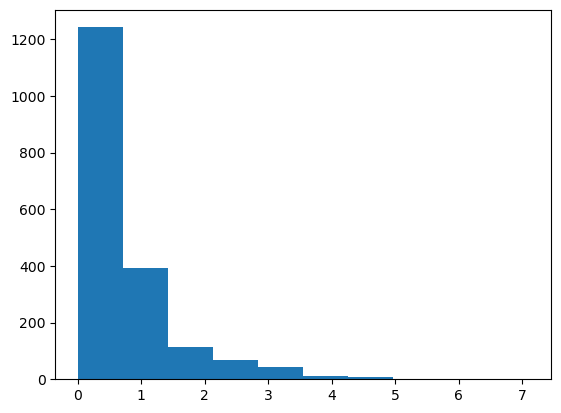

In [42]:
plt.hist(df[df['LegislationBuildingType']=="Multifamily Housing"]['GHGEmissionsIntensity'])
df[df['LegislationBuildingType']=="Multifamily Housing"]['GHGEmissionsIntensity'].describe()

In [38]:
# Which categories in the high intensity have a lot of spread?
# Look at the groups with the highest average intensity. From there, make a boxplot of those 
# How many entertainment, museums, repair services, data centers are there really? 
# Look at how many buildings there are in each of these heavy hitters. Eg. mobilize hospital workers to get a LOT of hospitals 
# Do this by collective emissions as well? multifamily emits the most, but they have the most buildings. 
top_intense_values = intensities[intensities.values> intensities.quantile(0.75)]
top_intense_types = list(top_intense_values.keys())
df_intense = df[df['EPAPropertyType'].isin(top_intense_types)]

mdf= df_intense[df_intense['GHGEmissionsIntensity'] > 6.0].melt(id_vars=['EPAPropertyType'], value_vars='GHGEmissionsIntensity')
chart = sns.boxplot(x='EPAPropertyType', y='value', data=mdf)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_ylabel("Emissions Intensity")

NameError: name 'intensities' is not defined

In [94]:
# Top 10 building types by total GHGE emissions
df.groupby(df['EPAPropertyType']).mean().sort_values(by='GHGEmissionsIntensity',ascending=True)[:10]

# Top 10 building types by average intensity

C:\Users\linne\AppData\Local\Temp\ipykernel_13732\558557071.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(df['EPAPropertyType']).mean().sort_values(by='GHGEmissionsIntensity',ascending=True)[:10]


,OSEBuildingID,CouncilDistrictCode,YearBuilt,PropertyGFABuilding(s),TotalGHGEmissions,GHGEmissionsIntensity
EPAPropertyType,,,,,,
Bank Branch,23730.000000,7.000000,1960.50000,28164.000000,2.050,0.050
Convenience Store without Gas Station,26594.000000,7.000000,1900.00000,21420.000000,3.200,0.100
Other - Education,27704.000000,5.000000,1988.00000,32961.000000,1.700,0.100
Energy/Power Station,19697.000000,4.000000,1923.00000,21462.000000,5.200,0.200
Food Service,21508.000000,7.000000,1930.00000,22710.000000,4.400,0.200
Movie Theater,24513.000000,5.000000,1986.00000,33392.000000,9.800,0.300
Self-Storage Facility,19906.595745,4.425532,1968.12766,79800.255319,24.715,0.475
Multifamily Housing,27112.250000,5.000000,1970.25000,144461.000000,70.675,0.475
Pre-school/Daycare,49938.500000,0.500000,2009.50000,42213.500000,20.100,0.500


# Spread of carbon intensity in top offenders
- Look at hospitals, labs, data centers, college/universities, supermarkets, restaurants, multi-family


In [7]:
df[df['EPAPropertyType'] == "Data Center"]

,OSEBuildingID,DataYear,BuildingName,BuildingType,TaxParcelIdentificationNumber,Address,City,State,ZipCode,Latitude,...,Electricity(kWh),SteamUse(kBtu),NaturalGas(therms),ComplianceStatus,ComplianceIssue,Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,geometry
234,365,2020,UW TOWER DATA CENTER,NonResidential,1142000290,4310 12TH AVE NE,SEATTLE,WA,98105.0,47.66060,...,9610516,0,0,Compliant,No Issue,32791081.0,0.0,174.4,4.8,POINT (-122.31512 47.66060)
3165,49780,2020,DATA CENTER,NonResidential,0659000905,2020 5TH AVE,SEATTLE,WA,98121.0,47.61449,...,25004180,0,0,Compliant,No Issue,85314262.0,0.0,453.7,9.6,POINT (-122.33956 47.61449)


In [108]:
# EPA Categories of interest
properties = ['Hospital (General Medical & Surgical)', 
                'Restaurant', 
                'Supermarket/Grocery Store', 
                'Prison/Incarceration', 
                'Lifestyle Center',
                'College/University', 
                'Data Center', 
                'Museum']

Text(0, 0.5, 'Emissions Intensity')

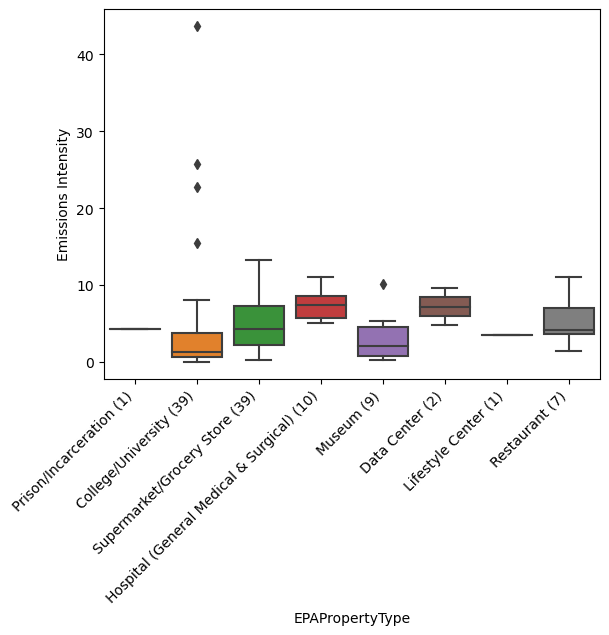

In [109]:
#chart = sns.boxplot(x='EPAPropertyType', y='GHGEmissionsIntensity', data=df[df['GHGEmissionsIntensity']> intensities.quantile(0.9)].sort_values('GHGEmissionsIntensity'))
chart = sns.boxplot(x='EPAPropertyType', y='GHGEmissionsIntensity', data=df[df['EPAPropertyType'].isin(properties)])
prop_nums = [p.get_text() + " (" + str(len(df[df['EPAPropertyType']==p.get_text()]))+ ")" for p in chart.get_xticklabels()]
chart.set_xticklabels(prop_nums, rotation=45, horizontalalignment='right')
chart.set_ylabel("Emissions Intensity")

### The Least Carbon-Efficient Building Types
1. Hospitals: On average, these buildings have the worst emissions intensity. There's also a good chunk of them likely in Kshama Sawant's D3. TBD if this is helpful or unhelpful, politically speaking. 
2. Supermarket/Grocery Store: These buidlings have the next work average emissions intensity. That being said, there's a wide spread of intensity values, while hospitals are more clustered around a universally bad value. See overall carbon footprint section as well, since there's so many of these building types. 
3. College/ University: Has the lowest average emissions intensity, but there's so many of the buildings (and so many students already in our base), that it's a very important category to look at. 

In [ ]:
worst_offenders = ["College/University", "Supermarket/Grocery Store", "Hospital (General Medical & Surgical)"]
display(df[df["EPAPropertyType"].isin(worst_offenders)])

### The Best of the Worst
1. Prisons:  There's only one prison in Seattle city limits in this dataset, and it's the King County Correctional Facility. Among all EPA property types, it's the 8th worst offender in terms of average emissions intensity. In terms of overall footprint it may not be as high as the sum total emissions of all grocery stores, but hey! If we abolish the police, this wouldn't be a problem at all!
    Another note: Police offices are also fairly carbon inefficient!

--> How does it total GHGE emissions of the prison relate to on average across all other buildings? Probably horribly. 

2. Lifestyle centers: This probably could go under malls and/or strip malls and would need further investigation. 

3. Data Centers: one belongs to UW and another is owned by a dubious agency (see tax parcel mappings), but a relevant data point could be that it's located in SLU. 

In [103]:
light_offenders = ["Prison/Incarceration", "Lifestyle Center", "Data Center"]
display(df[df["EPAPropertyType"].isin(light_offenders)])


,OSEBuildingID,BuildingName,CouncilDistrictCode,YearBuilt,TotalGHGEmissions,GHGEmissionsIntensity,EPAPropertyType,geometry,LegislationBuildingType
21,27,KING COUNTY CORRECTIONAL FACILITY,3.0,1985,1671.1,4.3,Prison/Incarceration,POINT (-122.32842 47.60378),Other
234,365,UW TOWER DATA CENTER,4.0,1969,174.4,4.8,Data Center,POINT (-122.31512 47.66060),Other
490,689,MARKETPLACE AT QUEEN ANNE SHOPPING CENTER,7.0,1994,288.7,3.5,Lifestyle Center,POINT (-122.35521 47.62476),Entertainment/Public Assembly
3165,49780,DATA CENTER,7.0,1975,453.7,9.6,Data Center,POINT (-122.33956 47.61449),Other


### Other Honorable Mentions
- Hotels: sounds like we have a lot of hotel workers on board for Electrify Seattle. 
- Museums: identified during the organizer retreat. Would need to look at carbon footprint, but aren't great in terms of efficiency. 

## Carbon Footprint by Building Type

In [110]:
footprints = df.groupby(df['EPAPropertyType'])['TotalGHGEmissions'].sum().sort_values(ascending=False)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pd.DataFrame(footprints))

                                                    TotalGHGEmissions
EPAPropertyType                                                      
Hospital (General Medical & Surgical)                         58799.7
Multifamily MR (5-9)                                          44670.8
Mixed Use Property                                            42247.9
Office                                                        40777.7
Multifamily HR (10+)                                          29035.9
College/University                                            26708.2
Multifamily LR (1-4)                                          25413.9
Hotel                                                         18808.1
Medical Office                                                14362.5
K-12 School                                                   12683.8
Other                                                         11469.7
Laboratory                                                     9300.7
Supermarket/Grocery 

TODO: Look into the breakdown of footprint more. 
- In terms of footprint, similar culprits like hospitals and colleges show up at the top. 
- Multi-family housing may be fairly carbon efficient per unit, but as a whole category it has a very large footprint. 
- Hotels show up here after being an honorable mention in intensity. 
- Schools also show up with a high footprint. 
- The single prison has approximately the same impact as each of res halls and courthouses...